# Section 1: Libraries and Drive connection


### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/My Drive/Computer Vision/Homework_CV/

### Import libraries

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
import pandas as pd
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [14]:
# Import other libraries
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import scipy
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Section 2: Data loading, augmentation and utils

### Load data

In the first section of the notebook we are going to perform an initial analysis of the data, focusing on:
- distribution of target classes
- understanding which type of data we have access to, via visualization

In [ ]:
data = np.load("data.npz", allow_pickle=True)
list(data.keys())

['data', 'labels', 'names']

In [ ]:
X, y, labels = data['data'], data['labels'], data['names']
print(X.shape, y.shape, labels)

(15092, 48, 48, 3) (15092, 1) {0: 'Basophil', 1: 'Eosinophil', 2: 'Erythroblast', 3: 'Immature Granulocyte', 4: 'Lymphocyte', 5: 'Monocyte', 6: 'Neutrophil', 7: 'Platelet'}


We have 15092 istances of white blood cells images with a resolution of 48x48 pixels, distributed in 8 different classes.

In [ ]:
count_classes = pd.Series(y.reshape(-1,))
count_classes = count_classes.apply(lambda x: labels.item()[x])
count_classes.value_counts()

Neutrophil              2939
Eosinophil              2752
Immature Granulocyte    2556
Platelet                2073
Erythroblast            1370
Monocyte                1254
Basophil                1076
Lymphocyte              1072
dtype: int64

As it is noticeable the classes in our data are not well balance , so we might take it into consideration when addressing the training, since unbalanced class could cause issues in the predictive perfomances of our model.

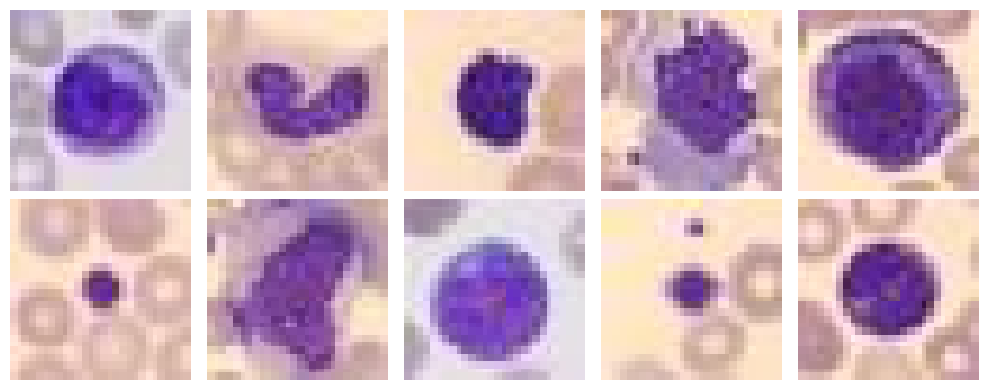

In [ ]:
# display some images

num_img = 10

fig, axes = plt.subplots(2, num_img//2, figsize = (10,4))

for i in range(num_img):
  ax = axes[i%2, i%num_img//2]
  ax.imshow(np.clip(X[i], 0, 255))
  ax.axis('off')
plt.tight_layout()
plt.show()

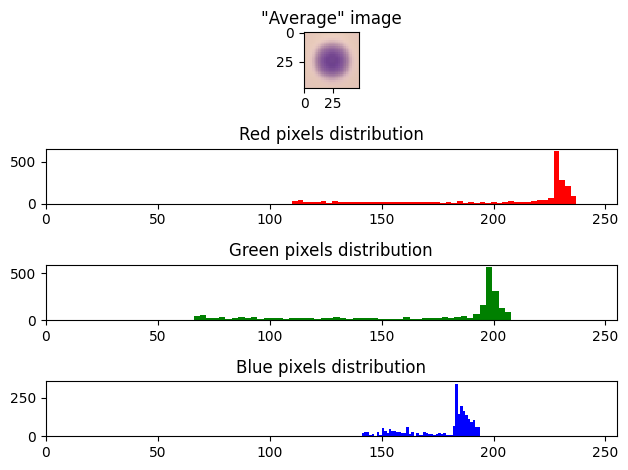

In [ ]:
hist_data = ((np.sum(X, axis = 0))/(X.shape[0])).astype(np.int32)
bins = 50
plt.subplot(4, 1, 1)
plt.imshow(hist_data)
plt.title('"Average" image')

plt.subplot(4, 1, 2)
plt.hist(hist_data[:,:,0].flatten(), color='r', bins=bins)
plt.xlim([0, 255])
plt.title('Red pixels distribution')

plt.subplot(4, 1, 3)
plt.hist(hist_data[:,:,1].flatten(), color='g', bins=bins)
plt.xlim([0, 255])
plt.title('Green pixels distribution')

plt.subplot(4, 1, 4)
plt.hist(hist_data[:,:,2].flatten(), color='b', bins=bins)
plt.xlim([0, 255])
plt.title('Blue pixels distribution')

plt.tight_layout()
plt.show()

In [ ]:
# Creation of train and test set

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.1, random_state = seed, stratify = y )

# Split into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = len(X_test), random_state = seed, stratify = y_train)

y_train = tfk.utils.to_categorical(y_train, 8)
y_val = tfk.utils.to_categorical(y_val, 8)
y_test = tfk.utils.to_categorical(y_test, 8)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (12072, 48, 48, 3), y_train shape: (12072, 8)
X_val shape: (1510, 48, 48, 3), y_val shape: (1510, 8)
X_test shape: (1510, 48, 48, 3), y_test shape: (1510, 8)


### Data augmentation


In [ ]:
def data_aug(train_data):

  #flip
  flip = tf.keras.Sequential([
  tfkl.RandomFlip("horizontal"),
  ])

  #translation
  translation = tf.keras.Sequential([
  tfkl.RandomTranslation(0.2,0.2),
  ])

  #rotation
  rotation = tf.keras.Sequential([
  tfkl.RandomRotation(0.3),
  ])

  #zoom
  zoom = tf.keras.Sequential([
  tfkl.RandomZoom(0.2),
  ])

  X_train_flip = tf.cast(flip(train_data), tf.int16)
  X_train_translation = tf.cast(translation(train_data), tf.int16)
  X_train_rotate = tf.cast(rotation(train_data), tf.int16)
  X_train_zoom = tf.cast(zoom(train_data), tf.int16)

  return X_train_flip, X_train_translation, X_train_rotate, X_train_zoom

X_train_flip, X_train_translation, X_train_rotate, X_train_zoom = data_aug(X_train)

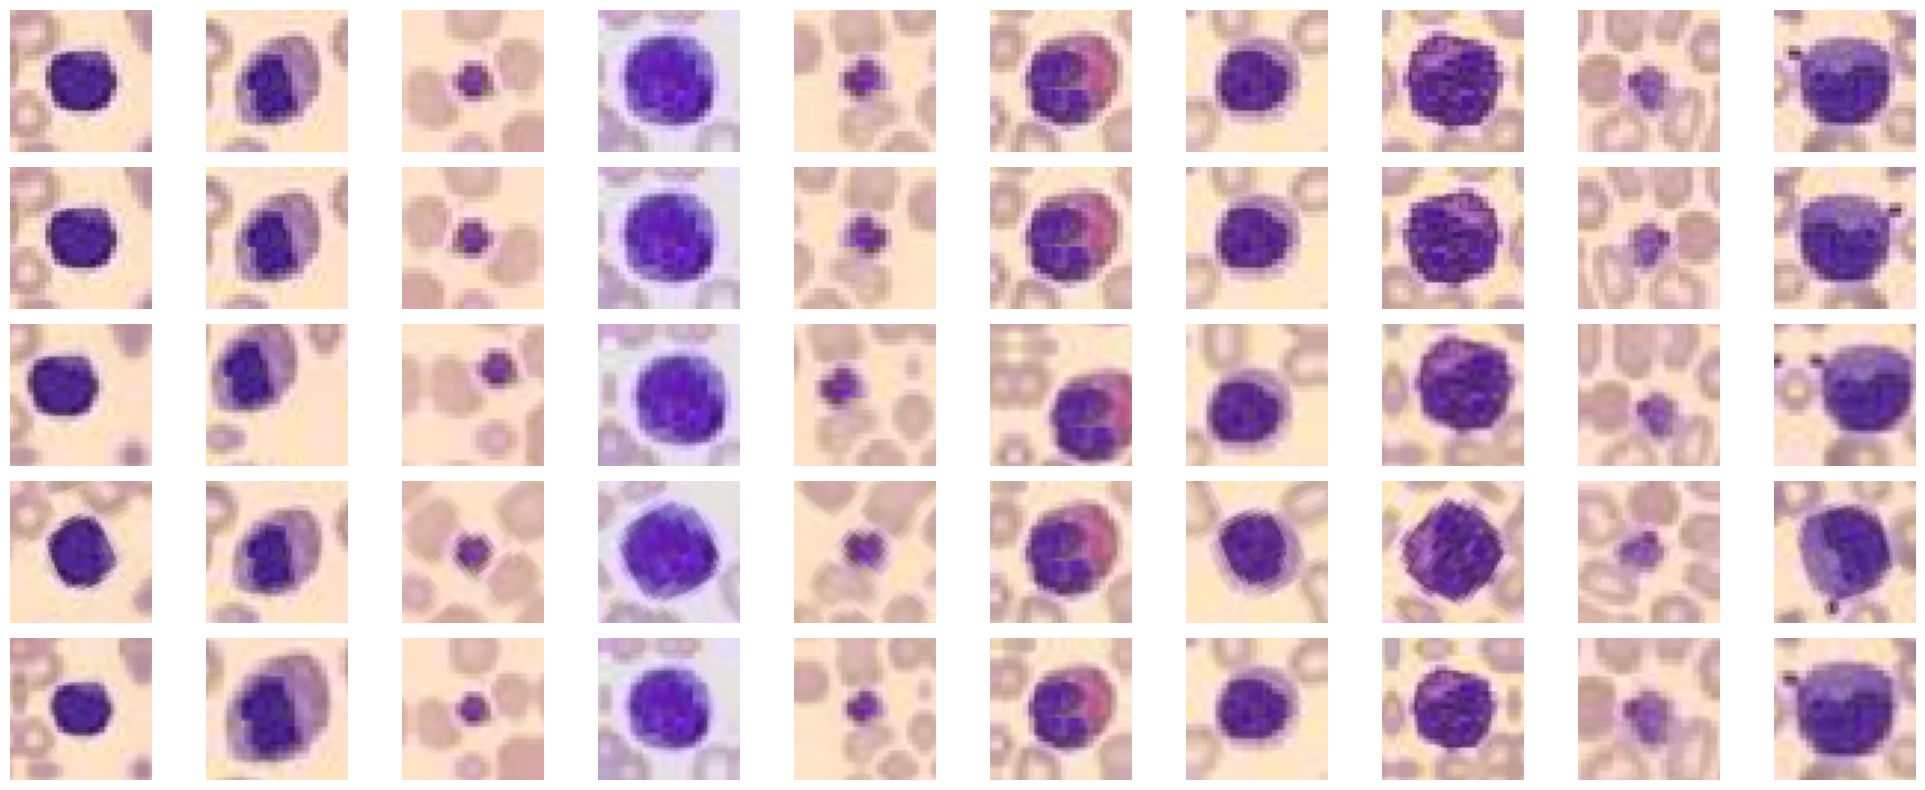

In [ ]:
num_img = 10
fig, axes = plt.subplots(5, num_img, figsize=(20,8))

for i in range(num_img):
    ax = axes[0,i%num_img]
    ax.imshow(X_train[i])
    ax.axis('off')

    ax = axes[1,i%num_img]
    ax.imshow(X_train_flip[i])
    ax.axis('off')

    ax = axes[2,i%num_img]
    ax.imshow(X_train_translation[i])
    ax.axis('off')

    ax = axes[3,i%num_img]
    ax.imshow(X_train_rotate[i])
    ax.axis('off')

    ax = axes[4,i%num_img]
    ax.imshow(X_train_zoom[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

### Utils

In [ ]:
# Plot the training history

def plot_history(history):
  '''
  Args:
    history (dict): history of training epochs

  Returns:
    Plot:
      - comparison between train and validation accuracy
      - comparison between train and validation loss
  '''
  fig, axes = plt.subplots(1, 2, figsize = (8,4))
  ax, ax1 = axes[0], axes[1]
  ax.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--', label='Train Loss')
  ax.plot(history['val_loss'], alpha=.8, color='#ff7f0e', label='Val Loss',)
  ax.legend(loc='upper right')
  ax.set_title('Loss')

  ax1.plot(history['accuracy'], alpha=.3, color='#055c1d', linestyle='--', label = 'Train Accuracy')
  ax1.plot(history['val_accuracy'], alpha=.8, color='#055c1d', label='Val Accuracy',)
  ax1.legend(loc='upper left')
  ax1.set_title('Accuracy')

  plt.grid(alpha=.3)
  plt.show()

In [ ]:
def plot_test_results(y_test, y_pred):
  '''
  This function is going to save a csv file to save the history of a model's train

  Args:
    y_test (np array): true target values of test set
    y_pred (np array): predicted target values of test set

  Returns:
    Display the confusion matrix and the associated scores for accuracy, precision, recall, F1
  '''

  cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(y_pred, axis=-1), normalize = 'pred')
  # Compute classification metrics
  accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(y_pred, axis=-1))
  precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(y_pred, axis=-1), average='macro')
  recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(y_pred, axis=-1), average='macro')
  f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(y_pred, axis=-1), average='macro')

  print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

  # Plot the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm.T, xticklabels=labels.item().values(), yticklabels=labels.item().values(), cmap='Blues', annot = True, fmt = '.2%')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

In [ ]:
def save_history(history, name):
  '''
  This function is going to save a csv file to save the history of a model's train

  Args:
    history (dict): history of training epochs
    name (str): name of the csv that has to be saved

  Returns:
    CSV file
  '''

  history_df = pd.DataFrame.from_dict(history)

  try:
      history_df.to_csv(f'{name}.csv')
      print('History successfully saved!')

  except:
      print('ERROR while saving the history')

In [ ]:
def min_max_prep(X_train, X_val, X_test):
  '''
  This function is going to preprocess all the data
  Args:
    train, validation, test set Xs and Ys

  Returns:
    min max normalized dataset
  '''

  # Calculate the maximum and minimum values for features in the training set
  max_df = X_train.max()
  min_df = X_train.min()

  # Normalize the features for all datasets (training, validation, and test)
  X_train = (X_train - min_df) / (max_df - min_df)
  X_val = (X_val - min_df) / (max_df - min_df)
  X_test = (X_test - min_df) / (max_df - min_df)

  return X_train, X_val, X_test

In [ ]:
# Define a convolutional block with batch normalization option
def conv_bn_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, batch_norm=True, name=''):
  '''
  Creating a simple convolutional block with batch normalization

  Args:
    x (tfk layer): previous layer
    filters (int): number of filters
    kernel size (int tuple): size of the filters
    padding (str): type of pudding (valid,same,full)
    downsample (bool): to add or not a MaxPooling layer
    activation (str): type of activation function to use
    stack (int): number of convolutional layer to add
    batch_norm (bool): add or not a batch norm
    name (str): name of convolutional block


  Returns:
    convolutional block
  '''

  # If downsample is True, apply max-pooling
  if downsample:
      x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

  # Apply a stack of convolutional layers with optional batch normalization and specified activation
  for s in range(stack):
      x = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x)
      if batch_norm:
          x = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x)
      x = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x)

  return x

In [ ]:
def conv_residual_block(x, filters, kernel_size, padding='same', downsample=True, activation='relu', stack=2, batch_norm=True, name=''):
    '''
    Creating a simple convolutional block with batch normalization and residual blocks

    Args:
      x (tfk layer): previous layer
      filters (int): number of filters
      kernel size (int tuple): size of the filters
      padding (str): type of pudding (valid,same,full)
      downsample (bool): to add or not a MaxPooling layer
      activation (str): type of activation function to use
      stack (int): number of convolutional layer to add
      batch_norm (bool): add or not a batch norm
      name (str): name of convolutional block


    Returns:
      convolutional block
    '''

    # If downsample is True, apply max-pooling
    if downsample:
        x = tfkl.MaxPooling2D(name='MaxPool_' + name)(x)

    # Create a copy of the input for the residual connection
    x_ = x

    # Apply a stack of convolutional layers to the copy
    for s in range(stack):
        x_ = tfkl.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, name='Conv_' + name + str(s+1))(x_)
        if batch_norm:
            x_ = tfkl.BatchNormalization(name='BatchNorm_' + name + str(s+1))(x_)
        x_ = tfkl.Activation(activation, name='Activation_' + name + str(s+1))(x_)

    # If downsample is True, apply a 1x1 convolution to match the number of filters
    if downsample:
        x = tfkl.Conv2D(filters=filters, kernel_size=1, padding=padding, name='Conv_' + name + 'skip')(x)

    # Add the original and the processed copy to create the residual connection
    x = tfkl.Add(name='Add_' + name)([x_, x])

    return x

In [ ]:
# CAM

def compute_CAM(model, img):
    '''
    Computings Class Activation Maps (CAM)

    Args:
      model (tensorflow model) : model for which we want to compute CAMs
      img (numpy array): image for which we want to display CAM

    Returns:
      final_output (numpy array): image with cam applied
      label_index (int): the index of the highest value prediction
      predictions (numpy array): probability predicted for every class
    '''
    # Expand image dimensions to fit the model input shape
    img = np.expand_dims(img, axis=0)

    # Predict to get the winning class
    predictions = model.predict(img, verbose=0)
    label_index = np.argmax(predictions)

    # Get the input weights to the softmax of the winning class
    class_weights = model.layers[-2].get_weights()[0]
    class_weights_winner = class_weights[:, label_index]

    # Define the final convolutional layer of the residual_model
    final_conv_layer = tfk.Model(
        model.input,
        model.get_layer('Conv_82').output
    )

    # Compute the convolutional outputs and squeeze the dimensions
    conv_outputs = final_conv_layer(img)
    conv_outputs = np.squeeze(conv_outputs)

    # Upsample the convolutional outputs and compute the final output using the class weights
    mat_for_mult = scipy.ndimage.zoom(conv_outputs, (8, 8, 1), order=1) # Provide the zoom factor as second argument
    final_output = np.dot(mat_for_mult.reshape((48*48, 512)), class_weights_winner).reshape(48, 48)

    return final_output, label_index, predictions

#labeling the CAMs plot
def tf(l_true, l_pred):
    if l_true == l_pred: return 'Correct prediction'
    else: return 'Wrong prediction'

# Section 3: Classification Task

### Transfer learning from a pretrained model on ImageNet

The purpose of this section is to analyze different pre-existing architecture and identify which are the ones that better perform on this dataset. We decided to start with these approach to see how much we can achieve with already pretrained models before going to actually implement some models from scratch.

In order we are going to try and compare:
  - MobileNetV3
  - VGG16
  - ResNet

All these models will be implemented using the 'ImageNet' weights

In [ ]:
def pretrained_models(ptmodel, name, input_shape = (48,48,3), output_shape = 8):

  ptmodel.trainable = False

  inputs = tfk.Input(shape=input_shape)

  x = ptmodel(inputs)
  x = tfkl.Flatten()(x)
  outputs = tfkl.Dense(output_shape, activation = 'softmax')(x)

  # Connect input and output to model class

  tf_model = tfk.Model(inputs = inputs, outputs = outputs, name = f'tl_{name}')
  tf_model.compile(loss = tfk.losses.CategoricalCrossentropy(), optimizer = tfk.optimizers.Adam(), metrics = 'accuracy')

  print(tf_model.summary())
  return tf_model

In [ ]:
tl_mobilev3 = pretrained_models(

    tfk.applications.MobileNetV3Large(
        input_shape = (48,48,3),
        include_top = False,
        weights = 'imagenet',
        pooling = 'avg'),
    'MobileV3'
)

Model: "tl_MobileV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 MobilenetV3large (Function  (None, 960)               2996352   
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense_9 (Dense)             (None, 8)                 7688      
                                                                 
Total params: 3004040 (11.46 MB)
Trainable params: 7688 (30.03 KB)
Non-trainable params: 2996352 (11.43 MB)
_________________________________________________________________
None


In [ ]:
history_mv3 = tl_mobilev3.fit(tfk.applications.mobilenet_v3.preprocess_input(X_train),
                       y_train,
                       batch_size = 32,
                       epochs = 300,
                       validation_data =(tfk.applications.mobilenet_v3.preprocess_input(X_val),y_val),
                       callbacks = [tfk.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                                patience = 25,
                                                                restore_best_weights = True,
                                                                mode = 'max')]).history

Epoch 1/300
378/378 [==============================] - 19s 36ms/step - loss: 1.0993 - accuracy: 0.6531 - val_loss: 0.7770 - val_accuracy: 0.7550
Epoch 2/300
378/378 [==============================] - 5s 14ms/step - loss: 0.6914 - accuracy: 0.7722 - val_loss: 0.6521 - val_accuracy: 0.7861
Epoch 3/300
378/378 [==============================] - 9s 23ms/step - loss: 0.6036 - accuracy: 0.8007 - val_loss: 0.6049 - val_accuracy: 0.8040
Epoch 4/300
378/378 [==============================] - 6s 16ms/step - loss: 0.5576 - accuracy: 0.8147 - val_loss: 0.5782 - val_accuracy: 0.8053
Epoch 5/300
378/378 [==============================] - 5s 14ms/step - loss: 0.5263 - accuracy: 0.8250 - val_loss: 0.5578 - val_accuracy: 0.8060
Epoch 6/300
378/378 [==============================] - 8s 21ms/step - loss: 0.5043 - accuracy: 0.8287 - val_loss: 0.5476 - val_accuracy: 0.8033
Epoch 7/300
378/378 [==============================] - 6s 15ms/step - loss: 0.4867 - accuracy: 0.8377 - val_loss: 0.5349 - val_accuracy

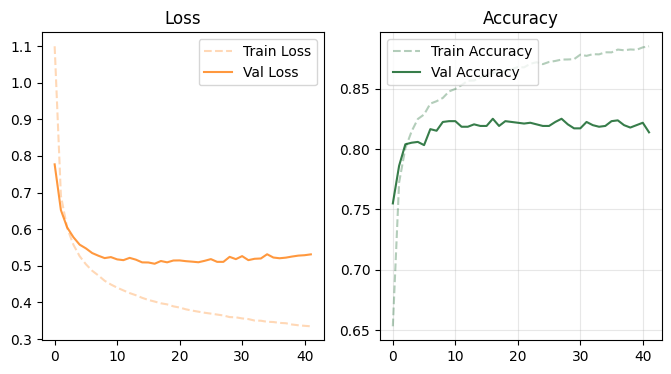

In [ ]:
plot_history(history_mv3)

In [ ]:
tl_vgg16 = pretrained_models(

    tfk.applications.VGG16(
        input_shape = (48,48,3),
        include_top = False,
        weights = 'imagenet',
        pooling = 'avg'),

    'VGG16')

Model: "tl_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 8)                 4104      
                                                                 
Total params: 14718792 (56.15 MB)
Trainable params: 4104 (16.03 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
None


In [ ]:
history_vgg16 = tl_vgg16.fit(tfk.applications.vgg16.preprocess_input(X_train),
                       y_train,
                       batch_size = 32,
                       epochs = 200,
                       validation_data =(tfk.applications.vgg16.preprocess_input(X_val),y_val),
                       callbacks = [tfk.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                                patience = 25,
                                                                restore_best_weights = True,
                                                                mode = 'max')]).history

Epoch 1/200
378/378 [==============================] - 7s 16ms/step - loss: 4.3067 - accuracy: 0.5538 - val_loss: 1.9022 - val_accuracy: 0.6914
Epoch 2/200
378/378 [==============================] - 6s 15ms/step - loss: 1.3721 - accuracy: 0.7339 - val_loss: 1.2678 - val_accuracy: 0.7477
Epoch 3/200
378/378 [==============================] - 6s 15ms/step - loss: 0.9643 - accuracy: 0.7720 - val_loss: 1.0029 - val_accuracy: 0.7788
Epoch 4/200
378/378 [==============================] - 6s 15ms/step - loss: 0.7985 - accuracy: 0.7899 - val_loss: 0.9534 - val_accuracy: 0.7629
Epoch 5/200
378/378 [==============================] - 6s 16ms/step - loss: 0.6970 - accuracy: 0.8011 - val_loss: 0.9535 - val_accuracy: 0.7709
Epoch 6/200
378/378 [==============================] - 6s 15ms/step - loss: 0.6448 - accuracy: 0.8079 - val_loss: 0.9128 - val_accuracy: 0.7709
Epoch 7/200
378/378 [==============================] - 6s 16ms/step - loss: 0.6207 - accuracy: 0.8105 - val_loss: 0.8296 - val_accuracy:

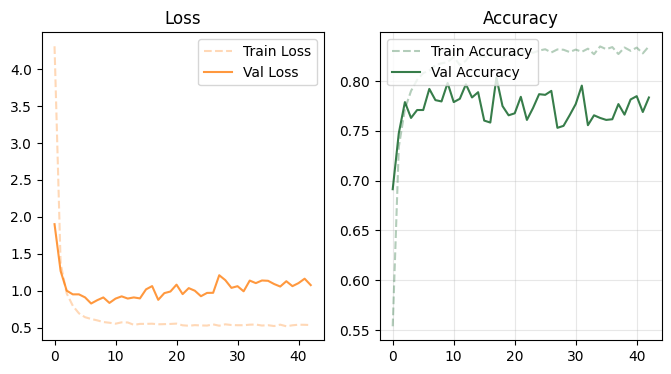

In [ ]:
plot_history(history_vgg16)

In [ ]:
# ResNet
tl_resnet = pretrained_models(
    tfk.applications.ResNet50V2(
        include_top = False,
        input_shape = (48,48,3),
        pooling = 'avg',
        weights = 'imagenet'),
    'ResNet50v2'
)

Model: "tl_ResNet50v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 48, 48, 3)]       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 8)                 16392     
                                                                 
Total params: 23581192 (89.96 MB)
Trainable params: 16392 (64.03 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________
None


In [ ]:
history_resv2 = tl_resnet.fit(
    tfk.applications.resnet_v2.preprocess_input(X_train),
    y_train,
    batch_size = 32,
    epochs = 300,
    validation_data = (tfk.applications.resnet_v2.preprocess_input(X_val), y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                             patience = 25,
                                             restore_best_weights = True,
                                             mode = 'max')]).history

Epoch 1/300
378/378 [==============================] - 11s 22ms/step - loss: 0.8879 - accuracy: 0.6938 - val_loss: 0.7127 - val_accuracy: 0.7583
Epoch 2/300
378/378 [==============================] - 6s 17ms/step - loss: 0.5992 - accuracy: 0.7916 - val_loss: 0.6969 - val_accuracy: 0.7629
Epoch 3/300
378/378 [==============================] - 7s 18ms/step - loss: 0.5223 - accuracy: 0.8152 - val_loss: 0.6049 - val_accuracy: 0.7993
Epoch 4/300
378/378 [==============================] - 6s 17ms/step - loss: 0.4734 - accuracy: 0.8306 - val_loss: 0.6105 - val_accuracy: 0.7874
Epoch 5/300
378/378 [==============================] - 7s 20ms/step - loss: 0.4387 - accuracy: 0.8421 - val_loss: 0.6001 - val_accuracy: 0.7967
Epoch 6/300
378/378 [==============================] - 6s 17ms/step - loss: 0.4089 - accuracy: 0.8528 - val_loss: 0.6158 - val_accuracy: 0.7960
Epoch 7/300
378/378 [==============================] - 10s 26ms/step - loss: 0.3950 - accuracy: 0.8566 - val_loss: 0.5972 - val_accurac

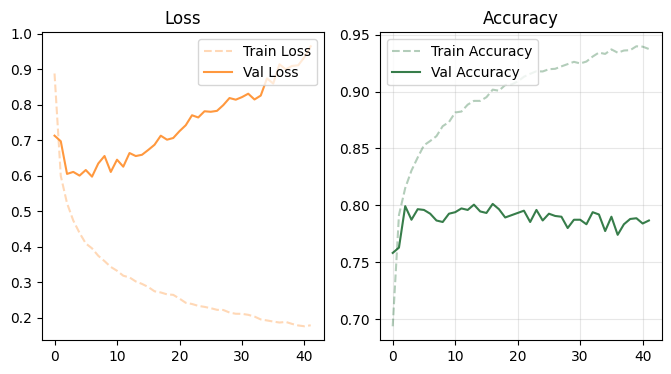

In [ ]:
plot_history(history_resv2)

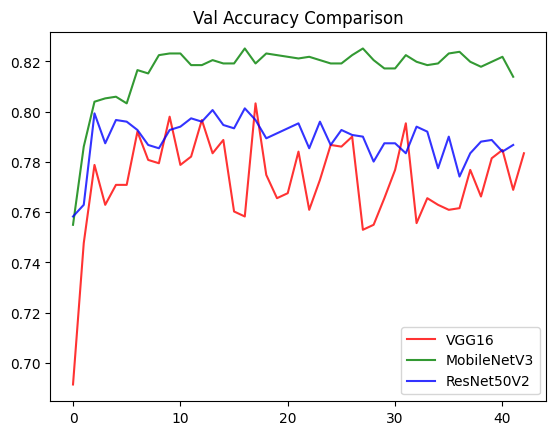

In [ ]:
plt.plot(history_vgg16['val_accuracy'], alpha=.8, color='r', label = 'VGG16')
plt.plot(history_mv3['val_accuracy'], alpha=.8, color='g',  label = 'MobileNetV3')
plt.plot(history_resv2['val_accuracy'], alpha=.8, color='b', label = 'ResNet50V2')
plt.title('Val Accuracy Comparison')
plt.legend()
plt.show()


**Comments:**
Even if there is a Model which is better than the other, the perfomance are clearly lacking in the accuracy, reaching a peak around 82/83% of validation accuracy. The latter result makes those network not usable in a real world context due to the poor perfomances in the classification task.

The problem might be caused by the istances on which these models have been pre-trained. In fact, even with changing the final part of the networks, called classifier, they are not able to grasp the real essence of these images probably due to the really different field they resemble to compared to the imagenet dataset. The latter is a dataset composed of many real world objects like cars, animals, fruits etc which posses patterns that are extremely different compared to biological/medical images.

### Simple NN

Since the first approach with the pre-trained models was unsuccessfull we decided to go through a different approach and build our own CNNs from scratch.

In [ ]:
X_train_prep, X_val_prep, X_test_prep = min_max_prep(X_train, X_val, X_test)

In [ ]:
# FIRST NN

input_shape = X_train_prep.shape[1:]
classes = 8

inputs = tfk.Input(input_shape)

#preprocessing
preproc = tfk.Sequential([
tfkl.RandomRotation(0.3),
tfkl.RandomZoom(0.2),
tfkl.RandomFlip("horizontal"),
], name = 'preprocessing')

preprocessing = preproc(inputs)


x = tfkl.Conv2D(32,
                (7,7),
                padding = 'same',
                activation ='relu')(preprocessing)

x = tfkl.Conv2D(64,
                (5,5),
                padding = 'same',
                activation ='relu')(x)

x = tfkl.MaxPooling2D(pool_size=(2,2))(x)

x = tfkl.Dropout(0.5) (x)

x = tfkl.Conv2D(128,
                (3,3),
                padding = 'same',
                activation ='relu')(x)

x = tfkl.Conv2D(256,
                (3,3),
                padding = 'same',
                activation ='relu')(x)

x = tfkl.MaxPooling2D(pool_size=(2,2))(x)

x = tfkl.Flatten()(x)

outputs = tfkl.Dense(classes, activation = 'softmax')(x)
model_1 = tfk.Model(inputs = inputs, outputs = outputs, name = 'CNN_1')

model_1.compile(optimizer= tfk.optimizers.Adam(), loss=tfk.losses.CategoricalFocalCrossentropy(), metrics=["accuracy"])

model_1.summary()

Model: "CNN_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 48, 48, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        4736      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        51264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                             

In [ ]:
history_CNN1 = model_1.fit(
    x = X_train_prep,
    y = y_train,
    validation_data = (X_val_prep, y_val),
    batch_size = 32,
    epochs = 300,
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)]
).history

Epoch 1/300
378/378 [==============================] - 12s 20ms/step - loss: 0.2212 - accuracy: 0.4869 - val_loss: 0.1592 - val_accuracy: 0.6921
Epoch 2/300
378/378 [==============================] - 7s 17ms/step - loss: 0.1295 - accuracy: 0.6714 - val_loss: 0.1271 - val_accuracy: 0.6854
Epoch 3/300
378/378 [==============================] - 7s 17ms/step - loss: 0.0935 - accuracy: 0.7540 - val_loss: 0.0832 - val_accuracy: 0.7868
Epoch 4/300
378/378 [==============================] - 7s 17ms/step - loss: 0.0848 - accuracy: 0.7712 - val_loss: 0.0763 - val_accuracy: 0.7927
Epoch 5/300
378/378 [==============================] - 7s 17ms/step - loss: 0.0702 - accuracy: 0.8070 - val_loss: 0.0656 - val_accuracy: 0.8079
Epoch 6/300
378/378 [==============================] - 7s 18ms/step - loss: 0.0638 - accuracy: 0.8260 - val_loss: 0.0626 - val_accuracy: 0.8305
Epoch 7/300
378/378 [==============================] - 7s 18ms/step - loss: 0.0617 - accuracy: 0.8259 - val_loss: 0.0574 - val_accuracy

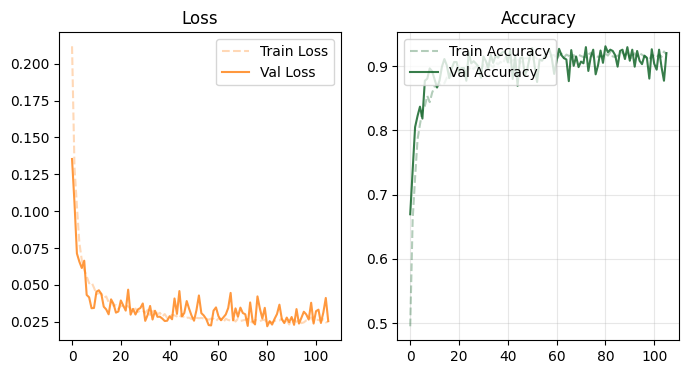

In [ ]:
plot_history(history_CNN1)

In [ ]:
# SECOND NN with all (3,3) filters

input_shape = X_train_prep.shape[1:]
classes = 8

inputs = tfk.Input(input_shape)

# Preprocessing
preproc = tfk.Sequential([
tfkl.RandomRotation(0.3),
tfkl.RandomZoom(0.2),
tfkl.RandomFlip("horizontal"),
], name = 'preprocessing')

preprocessing = preproc(inputs)


x = tfkl.Conv2D(32,
                (3,3),
                padding = 'same',
                activation ='relu')(preprocessing)

x = tfkl.Conv2D(64,
                (3,3),
                padding = 'same',
                activation ='relu')(x)

x = tfkl.MaxPooling2D(pool_size=(2,2))(x)

# x = tfkl.Dropout(0.5) (x)

x = tfkl.Conv2D(128,
                (3,3),
                padding = 'same',
                activation ='relu')(x)

x = tfkl.Conv2D(256,
                (3,3),
                padding = 'same',
                activation ='relu')(x)

x = tfkl.MaxPooling2D(pool_size=(2,2))(x)


x = tfkl.Flatten()(x)

x = tfkl.Dense(64, activation = 'relu')(x)

outputs = tfkl.Dense(classes, activation = 'softmax')(x)
model_2 = tfk.Model(inputs = inputs, outputs = outputs, name = 'CNN_2')

model_2.compile(optimizer= tfk.optimizers.Adam(), loss=tfk.losses.CategoricalFocalCrossentropy(), metrics=["accuracy"])

model_2.summary()

Model: "CNN_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 48, 48, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 24, 24, 128)       73856     
                                                             

In [ ]:
history_CNN2 = model_2.fit(
    x = X_train_prep,
    y = y_train,
    validation_data = (X_val_prep, y_val),
    batch_size = 32,
    epochs = 300,
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True)]
).history

Epoch 1/300
378/378 [==============================] - 8s 17ms/step - loss: 0.2237 - accuracy: 0.4701 - val_loss: 0.1379 - val_accuracy: 0.6510
Epoch 2/300
378/378 [==============================] - 5s 14ms/step - loss: 0.1370 - accuracy: 0.6504 - val_loss: 0.1113 - val_accuracy: 0.7066
Epoch 3/300
378/378 [==============================] - 6s 16ms/step - loss: 0.1147 - accuracy: 0.7026 - val_loss: 0.0742 - val_accuracy: 0.7821
Epoch 4/300
378/378 [==============================] - 6s 15ms/step - loss: 0.0928 - accuracy: 0.7497 - val_loss: 0.0716 - val_accuracy: 0.8026
Epoch 5/300
378/378 [==============================] - 6s 15ms/step - loss: 0.0798 - accuracy: 0.7806 - val_loss: 0.0604 - val_accuracy: 0.8166
Epoch 6/300
378/378 [==============================] - 6s 16ms/step - loss: 0.0731 - accuracy: 0.7965 - val_loss: 0.0514 - val_accuracy: 0.8536
Epoch 7/300
378/378 [==============================] - 6s 15ms/step - loss: 0.0677 - accuracy: 0.8094 - val_loss: 0.0458 - val_accuracy:

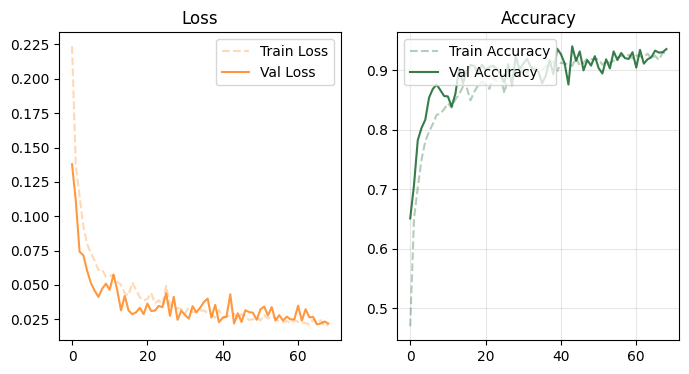

In [ ]:
plot_history(history_CNN2) # Applying constrast transformation

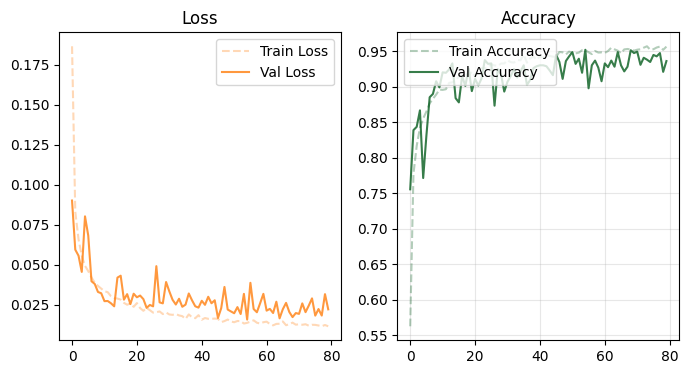

In [ ]:
plot_history(history_CNN2) # same model changed without constrats is slightly better

48/48 [==============================] - 0s 5ms/step
Accuracy: 0.9517, Precision: 0.9471, Recall: 0.9458, F1: 0.9462


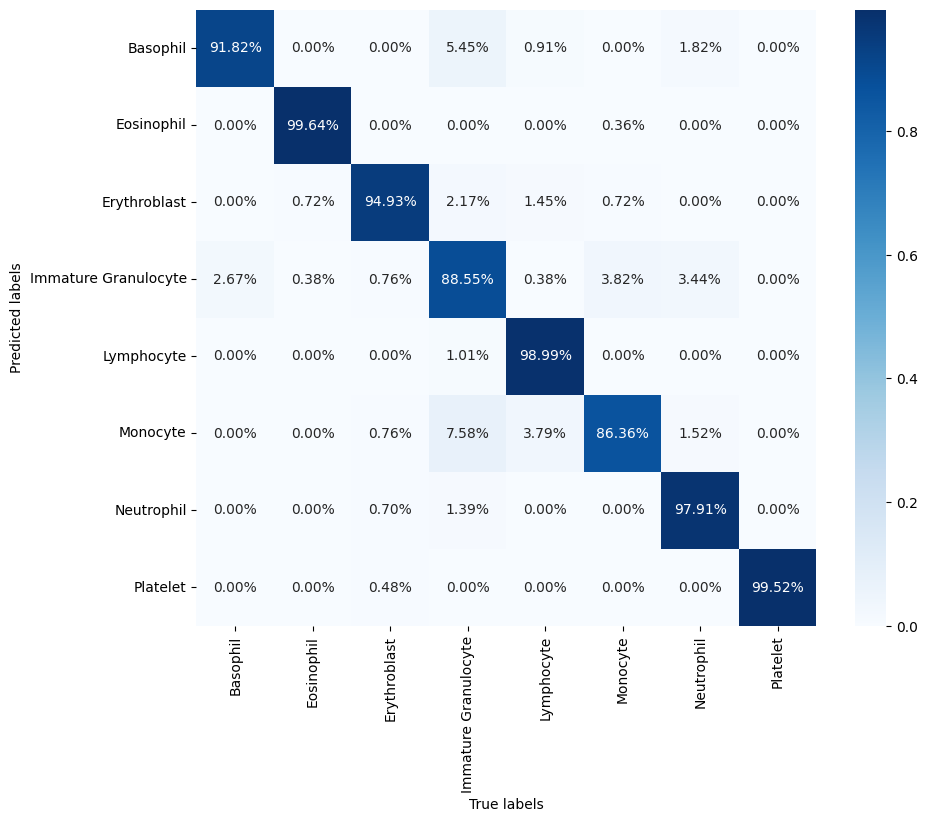

In [ ]:
pred2 = model_2.predict(X_test_prep)
plot_test_results(y_test, pred2)


### Deeper CNN
with preproc and real augmentation

In [ ]:
X_train_concat = np.concatenate([
    X_train_flip,
    X_train_translation,
    X_train_rotate,
    # X_train_zoom
    ], axis=0)

y_train_aug = np.concatenate([y_train]*3,axis=0)

X_train_aug_prep, X_val_aug_prep, X_test_aug_prep = min_max_prep(X_train_concat, X_val, X_test)

In [ ]:
input_shape=X_train.shape[1:]
output_shape=8

def deeper_model(input_shape=input_shape, output_shape=output_shape, augmented = False, name =''):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    if augmented == False:
      #preprocessing
      preproc = tfk.Sequential([
      tfkl.RandomRotation(0.3),
      tfkl.RandomZoom(0.2),
      tfkl.RandomFlip("horizontal"),
      ], name = 'preprocessing')

      preprocessing = preproc(input_layer)
      x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(preprocessing)

    else:
      #try with real augmentation of data (i.e. creating a new dataset for every transformation)
      x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(input_layer)


    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.ReLU(name='relu2')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.ReLU(name='relu3')(x)
    x = tfkl.MaxPooling2D(name='mp3')(x)

    x = tfkl.Conv2D(filters=512, kernel_size=3, padding='same', name='conv4')(x)
    x = tfkl.ReLU(name='relu4')(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    x = tfkl.Dense(8, activation = 'relu', name='CamLayer')(x) # we tried to add an fc layer to be able to perform a CAM later on

    output_layer = tfkl.Dense(units=8, activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name=f'CNN_{name}')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

    # Return the model
    return model

In [ ]:
model_waug = deeper_model(name='waug')
model_waug.summary()

Model: "CNN_waug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 48, 48, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 48, 48, 3)         0         
                                                                 
 conv0 (Conv2D)              (None, 48, 48, 32)        896       
                                                                 
 relu0 (ReLU)                (None, 48, 48, 32)        0         
                                                                 
 mp0 (MaxPooling2D)          (None, 24, 24, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 64)        18496     
                                                                 
 relu1 (ReLU)                (None, 24, 24, 64)        0  

In [ ]:
history_model_waug = model_waug.fit(
    x = X_train_prep,
    y = y_train,
    validation_data = (X_val_prep, y_val),
    batch_size = 32,
    epochs = 300,
    callbacks=[tfk.callbacks.EarlyStopping(monitor="val_accuracy", patience= 25, restore_best_weights= True)]
).history

Epoch 1/300
378/378 [==============================] - 16s 12ms/step - loss: 1.7113 - accuracy: 0.3022 - val_loss: 1.4668 - val_accuracy: 0.3536
Epoch 2/300
378/378 [==============================] - 7s 18ms/step - loss: 1.3846 - accuracy: 0.4488 - val_loss: 1.1302 - val_accuracy: 0.5430
Epoch 3/300
378/378 [==============================] - 8s 21ms/step - loss: 1.1085 - accuracy: 0.5475 - val_loss: 0.9127 - val_accuracy: 0.6344
Epoch 4/300
378/378 [==============================] - 8s 21ms/step - loss: 0.8210 - accuracy: 0.6742 - val_loss: 0.6773 - val_accuracy: 0.7563
Epoch 5/300
378/378 [==============================] - 6s 15ms/step - loss: 0.6072 - accuracy: 0.7773 - val_loss: 0.5262 - val_accuracy: 0.8152
Epoch 6/300
378/378 [==============================] - 8s 22ms/step - loss: 0.5474 - accuracy: 0.8002 - val_loss: 0.5055 - val_accuracy: 0.8179
Epoch 7/300
378/378 [==============================] - 6s 15ms/step - loss: 0.4921 - accuracy: 0.8193 - val_loss: 0.4745 - val_accuracy

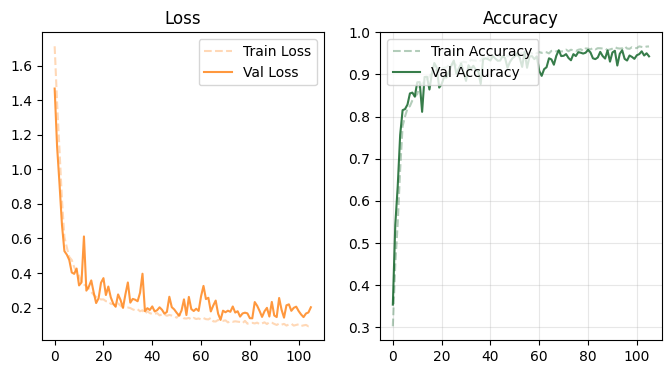

In [ ]:
plot_history(history_model_waug)

In [ ]:
save_history(history_model_waug, 'history_model_waug')

History successfully saved!


48/48 [==============================] - 0s 3ms/step
Accuracy: 0.9483, Precision: 0.9434, Recall: 0.9406, F1: 0.9406


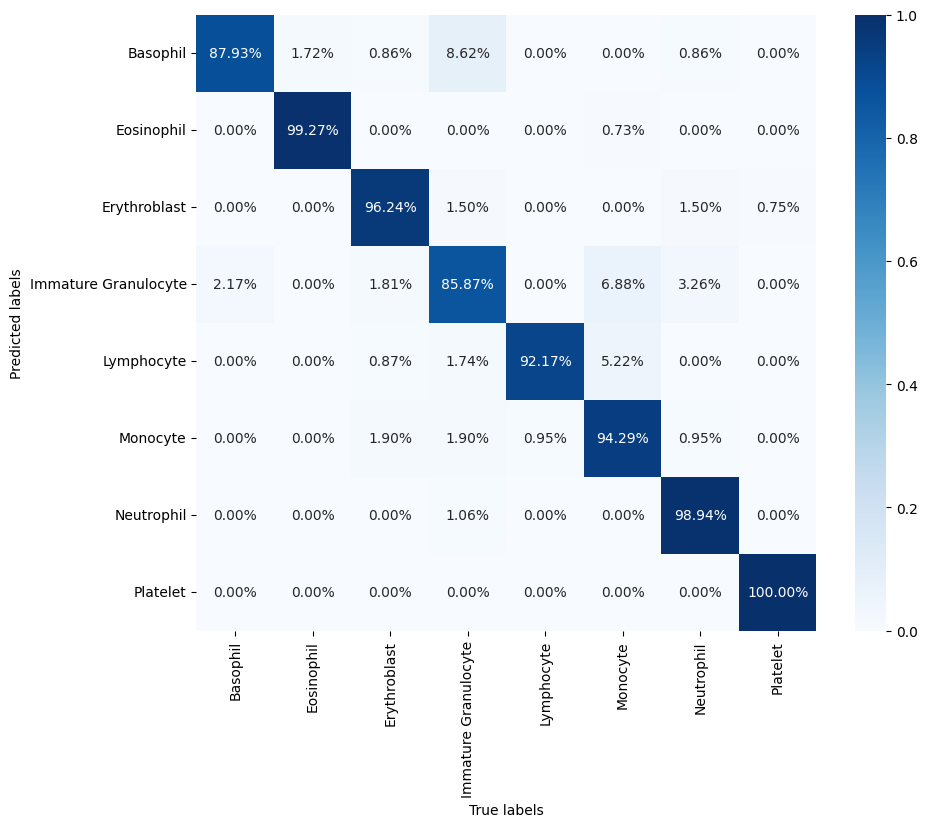

In [ ]:
pred_waug = model_waug.predict(X_test_prep)
plot_test_results(y_test, pred_waug)

In [ ]:
model_aug = deeper_model(name='aug', augmented=True)
model_aug.summary()

Model: "CNN_aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 48, 48, 3)]       0         
                                                                 
 conv0 (Conv2D)              (None, 48, 48, 32)        896       
                                                                 
 relu0 (ReLU)                (None, 48, 48, 32)        0         
                                                                 
 mp0 (MaxPooling2D)          (None, 24, 24, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 64)        18496     
                                                                 
 relu1 (ReLU)                (None, 24, 24, 64)        0         
                                                                 
 mp1 (MaxPooling2D)          (None, 12, 12, 64)        0   

In [ ]:
history_model_aug = model_aug.fit(
    x = X_train_aug_prep,
    y = y_train_aug,
    validation_data = (X_val_aug_prep, y_val),
    batch_size = 32,
    epochs = 300,
    callbacks=[tfk.callbacks.EarlyStopping(monitor="val_accuracy", patience= 25, restore_best_weights= True)]
).history

Epoch 1/300
1509/1509 [==============================] - 12s 7ms/step - loss: 0.8904 - accuracy: 0.6581 - val_loss: 0.5265 - val_accuracy: 0.8020
Epoch 2/300
1509/1509 [==============================] - 10s 6ms/step - loss: 0.4617 - accuracy: 0.8308 - val_loss: 0.3958 - val_accuracy: 0.8576
Epoch 3/300
1509/1509 [==============================] - 9s 6ms/step - loss: 0.3312 - accuracy: 0.8830 - val_loss: 0.3093 - val_accuracy: 0.8914
Epoch 4/300
1509/1509 [==============================] - 10s 6ms/step - loss: 0.2707 - accuracy: 0.9050 - val_loss: 0.2788 - val_accuracy: 0.9113
Epoch 5/300
1509/1509 [==============================] - 10s 6ms/step - loss: 0.2324 - accuracy: 0.9194 - val_loss: 0.2489 - val_accuracy: 0.9172
Epoch 6/300
1509/1509 [==============================] - 10s 6ms/step - loss: 0.1965 - accuracy: 0.9323 - val_loss: 0.1862 - val_accuracy: 0.9344
Epoch 7/300
1509/1509 [==============================] - 10s 6ms/step - loss: 0.1688 - accuracy: 0.9410 - val_loss: 0.1986 - 

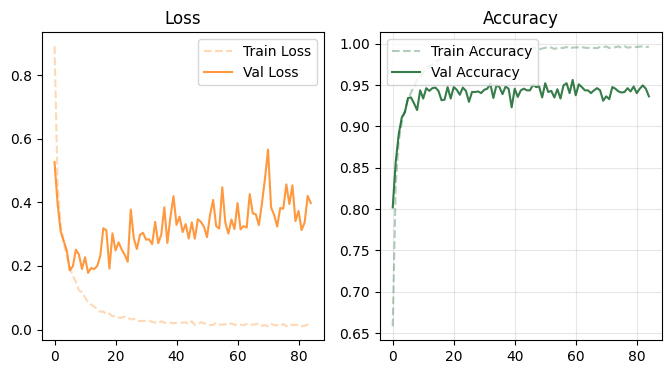

In [ ]:
plot_history(history_model_aug)

In [ ]:
save_history(history_model_aug, 'history_model_aug')

History successfully saved!


48/48 [==============================] - 0s 3ms/step
Accuracy: 0.9517, Precision: 0.9458, Recall: 0.9451, F1: 0.9447


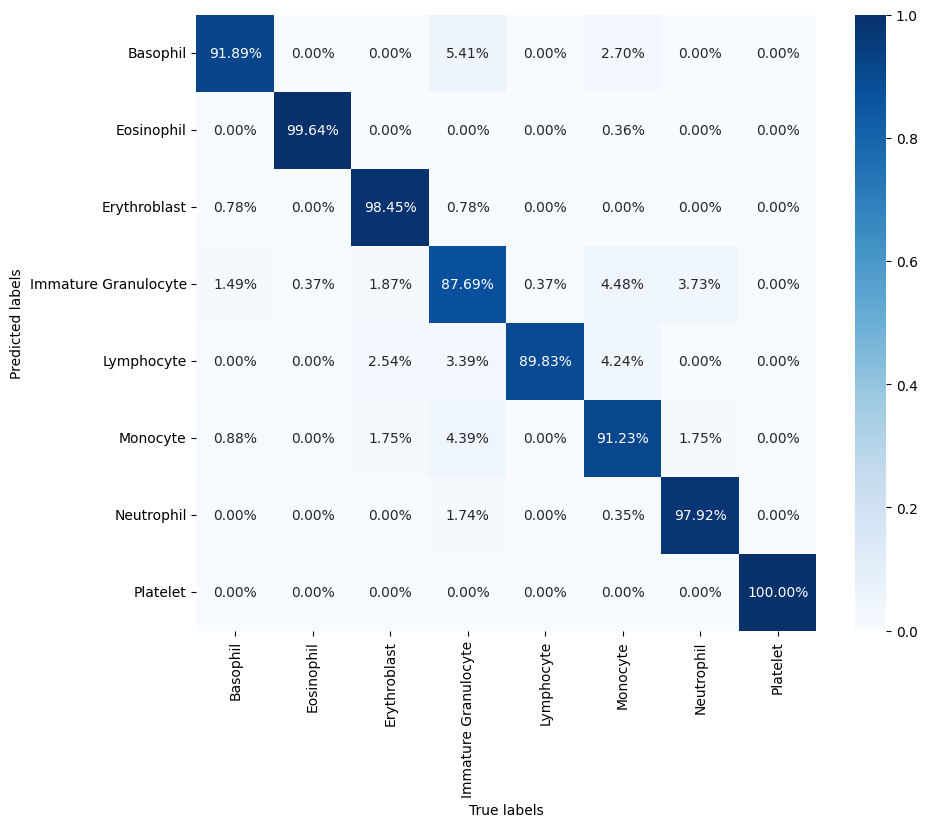

In [ ]:
pred_aug = model_aug.predict(X_test_aug_prep)
plot_test_results(y_test, pred_aug)

### Deeper CNN with Batch Norm

In [ ]:
# with batch norm
input_shape=X_train.shape[1:]
output_shape=8

def build_bn_model(input_shape=input_shape, output_shape=output_shape, learning_rate=1e-4, seed=seed):

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input_Layer')

    # # Define a preprocessing Sequential model with random flip, zero padding, and random crop
    # preprocessing = tfk.Sequential([
    #     tfkl.RandomFlip('horizontal', name='RandomFlip_horizontal'),
    #     tfkl.ZeroPadding2D((2, 2), name='ZeroPadding_2x2'),
    #     tfkl.RandomCrop(input_shape[0], input_shape[1], name='RandomCrop')
    # ], name='Preprocessing')

    # Apply preprocessing to the input layer
    # x0 = preprocessing(input_layer)

    # Initial convolution with batch normalization and activation
    x0 = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv0')(input_layer)
    # x0 = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv0')(x0)
    x0 = tfkl.BatchNormalization(name='BatchNorm0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create convolutional blocks with batch normalization
    x1 = conv_bn_block(x=x0, filters=64, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='1')
    x1 = conv_bn_block(x=x1, filters=64, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='2')

    x2 = conv_bn_block(x=x1, filters=128, kernel_size=3, downsample=True, stack=2, batch_norm=True, name='3')
    x2 = conv_bn_block(x=x2, filters=128, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='4')

    x3 = conv_bn_block(x=x2, filters=256, kernel_size=3, downsample=True, stack=2, batch_norm=True, name='5')
    x3 = conv_bn_block(x=x3, filters=256, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='6')

    x4 = conv_bn_block(x=x3, filters=512, kernel_size=3, downsample=True, stack=2, batch_norm=True, name='7')
    x4 = conv_bn_block(x=x4, filters=512, kernel_size=3, downsample=False, stack=2, batch_norm=True, name='8')

    # Global Average Pooling and classifier
    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x4)

    x = tfkl.Dense(output_shape, name='Dense')(x)
    output_activation = tfkl.Activation('softmax', name='Softmax')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='VGG18_BN')

    # Define optimizer, loss, and metrics
    # AdamW is an Adam optimizer which applies weight_decay to network layers,
    # i.e it's another way to apply l2 regularization to the whole network
    optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
    loss = tfk.losses.CategoricalCrossentropy()
    metrics = ['accuracy']

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [ ]:
bn_model = build_bn_model()
bn_model.summary()

Model: "VGG18_BN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 48, 48, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 48, 48, 64)        1792      
                                                                 
 BatchNorm0 (BatchNormaliza  (None, 48, 48, 64)        256       
 tion)                                                           
                                                                 
 ReLU0 (Activation)          (None, 48, 48, 64)        0         
                                                                 
 Conv_11 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 BatchNorm_11 (BatchNormali  (None, 48, 48, 64)        256       
 zation)                                                  

In [ ]:
bn_history = bn_model.fit(
    X_train_aug_prep,
    y_train_aug,
    validation_data=(X_val_aug_prep, y_val),
    epochs= 300,
    batch_size= 32,
    verbose=1,
    callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')]
).history

Epoch 1/300
1132/1132 [==============================] - 39s 26ms/step - loss: 0.3741 - accuracy: 0.8659 - val_loss: 0.4231 - val_accuracy: 0.8656 - lr: 1.0000e-04
Epoch 2/300
1132/1132 [==============================] - 29s 25ms/step - loss: 0.2223 - accuracy: 0.9218 - val_loss: 0.5223 - val_accuracy: 0.8556 - lr: 1.0000e-04
Epoch 3/300
1132/1132 [==============================] - 29s 26ms/step - loss: 0.1748 - accuracy: 0.9395 - val_loss: 0.3420 - val_accuracy: 0.9073 - lr: 1.0000e-04
Epoch 4/300
1132/1132 [==============================] - 29s 26ms/step - loss: 0.1455 - accuracy: 0.9498 - val_loss: 0.5067 - val_accuracy: 0.8656 - lr: 1.0000e-04
Epoch 5/300
1132/1132 [==============================] - 28s 25ms/step - loss: 0.1254 - accuracy: 0.9559 - val_loss: 0.5324 - val_accuracy: 0.8457 - lr: 1.0000e-04
Epoch 6/300
1132/1132 [==============================] - 29s 25ms/step - loss: 0.1079 - accuracy: 0.9633 - val_loss: 0.1803 - val_accuracy: 0.9430 - lr: 1.0000e-04
Epoch 7/300
1132

In [ ]:
save_history(bn_history, 'bn_vgg18_aug') # Save the model with no data augmentation

History successfully saved!


In [ ]:
bn_model.save('VGG18 like batch norm aug')

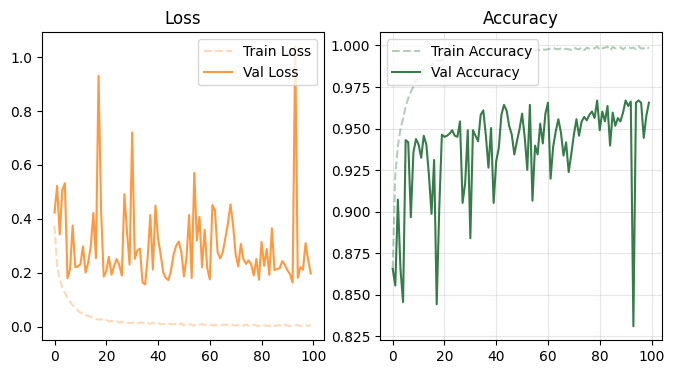

In [ ]:
plot_history(bn_history)

48/48 [==============================] - 1s 7ms/step
Accuracy: 0.9682, Precision: 0.9691, Recall: 0.9619, F1: 0.9653


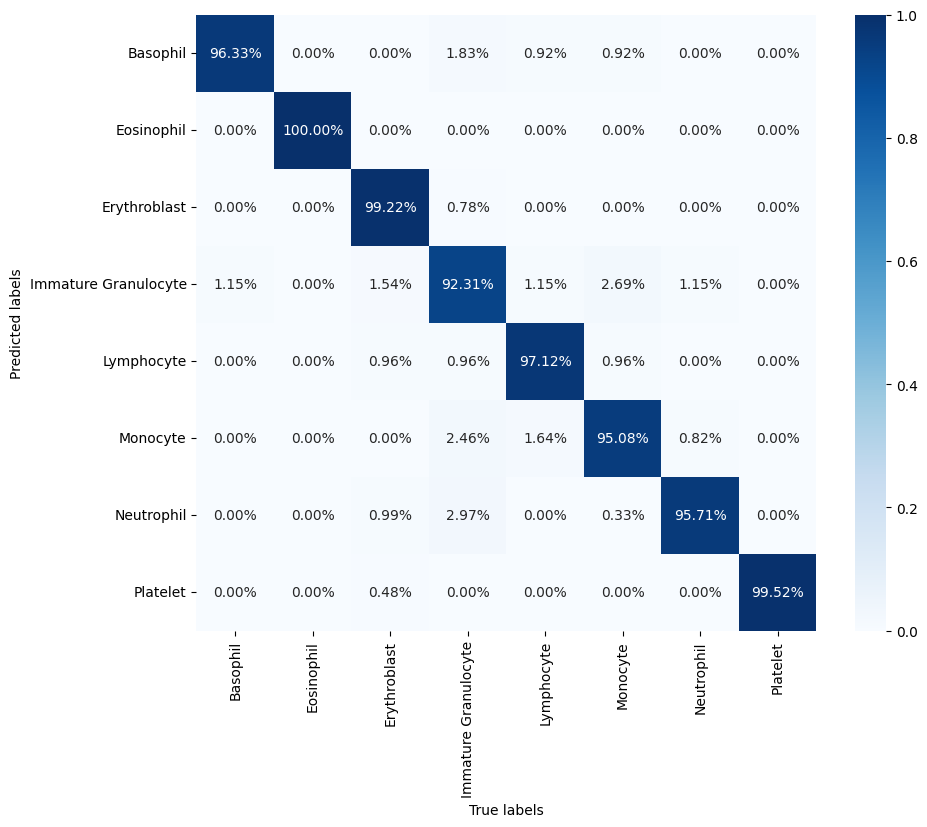

In [ ]:
predictions = bn_model.predict(X_test_aug_prep)
plot_test_results(y_test, predictions)

### Deeper CNN with Batch Norm and Skip Connections

In [ ]:
input_shape=X_train.shape[1:]
output_shape=8

# Define a function to build a VGG18-like model with residual blocks
def build_model_residual(input_shape=input_shape, output_shape=output_shape, learning_rate=1e-4, seed=seed):

    # Input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input_Layer')

    # # Define a preprocessing Sequential model with random flip, zero padding, and random crop
    # preprocessing = tfk.Sequential([
    #     tfkl.RandomFlip('horizontal', name='RandomFlip_horizontal'),
    #     tfkl.ZeroPadding2D((2, 2), name='ZeroPadding_2x2'),
    #     tfkl.RandomCrop(input_shape[0], input_shape[1], name='RandomCrop')
    # ], name='Preprocessing')

    # # Apply preprocessing to the input layer
    # x0 = preprocessing(input_layer)

    # Initial convolution with batch normalization and activation
    x0 = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='Conv0')(input_layer)
    x0 = tfkl.BatchNormalization(name='BatchNorm0')(x0)
    x0 = tfkl.Activation('relu', name='ReLU0')(x0)

    # Create residual blocks
    x1 = conv_residual_block(x=x0, filters=64, kernel_size=3, downsample=False, stack=2, name='1')
    x1 = conv_residual_block(x=x1, filters=64, kernel_size=3, downsample=False, stack=2, name='2')

    x2 = conv_residual_block(x=x1, filters=128, kernel_size=3, downsample=True, stack=2, name='3')
    x2 = conv_residual_block(x=x2, filters=128, kernel_size=3, downsample=False, stack=2, name='4')

    x3 = conv_residual_block(x=x2, filters=256, kernel_size=3, downsample=True, stack=2, name='5')
    x3 = conv_residual_block(x=x3, filters=256, kernel_size=3, downsample=False, stack=2, name='6')

    x4 = conv_residual_block(x=x3, filters=512, kernel_size=3, downsample=True, stack=2, name='7')
    x4 = conv_residual_block(x=x4, filters=512, kernel_size=3, downsample=False, stack=2, name='8')

    # Global Average Pooling and classifier
    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x4)
    x = tfkl.Dense(output_shape, name='Dense')(x)
    output_activation = tfkl.Activation('softmax', name='Softmax')(x)

    # Create the model
    model = tfk.Model(inputs=input_layer, outputs=output_activation, name='VGG18_Residual')

    # Define optimizer, loss, and metrics
    # AdamW is an Adam optimizer which applies weight_decay to network layers,
    # i.e it's another way to apply l2 regularization to the whole network
    optimizer = tfk.optimizers.AdamW(learning_rate, weight_decay=5e-4)
    loss = tfk.losses.CategoricalCrossentropy()
    metrics = ['accuracy']

    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [ ]:
residual_model = build_model_residual()
residual_model.summary()

Model: "VGG18_Residual"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 Conv0 (Conv2D)              (None, 48, 48, 64)           1792      ['Input_Layer[0][0]']         
                                                                                                  
 BatchNorm0 (BatchNormaliza  (None, 48, 48, 64)           256       ['Conv0[0][0]']               
 tion)                                                                                            
                                                                                                  
 ReLU0 (Activation)          (None, 48, 48, 64)           0         ['BatchNorm0[0][0

In [ ]:
residual_history = residual_model.fit(
    X_train_aug_prep,
    y_train_aug,
    validation_data=(X_val_aug_prep, y_val),
    epochs=300,
    batch_size=32,
    verbose=1,
    callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')]
).history

Epoch 1/300
1132/1132 [==============================] - 43s 28ms/step - loss: 0.3496 - accuracy: 0.8796 - val_loss: 0.3768 - val_accuracy: 0.8748 - lr: 1.0000e-04
Epoch 2/300
1132/1132 [==============================] - 31s 28ms/step - loss: 0.1958 - accuracy: 0.9305 - val_loss: 0.5721 - val_accuracy: 0.8490 - lr: 1.0000e-04
Epoch 3/300
1132/1132 [==============================] - 31s 27ms/step - loss: 0.1488 - accuracy: 0.9476 - val_loss: 0.7199 - val_accuracy: 0.7881 - lr: 1.0000e-04
Epoch 4/300
1132/1132 [==============================] - 31s 28ms/step - loss: 0.1214 - accuracy: 0.9570 - val_loss: 0.6200 - val_accuracy: 0.8325 - lr: 1.0000e-04
Epoch 5/300
1132/1132 [==============================] - 31s 28ms/step - loss: 0.0997 - accuracy: 0.9665 - val_loss: 0.1899 - val_accuracy: 0.9430 - lr: 1.0000e-04
Epoch 6/300
1132/1132 [==============================] - 31s 27ms/step - loss: 0.0814 - accuracy: 0.9715 - val_loss: 0.3571 - val_accuracy: 0.8954 - lr: 1.0000e-04
Epoch 7/300
1132

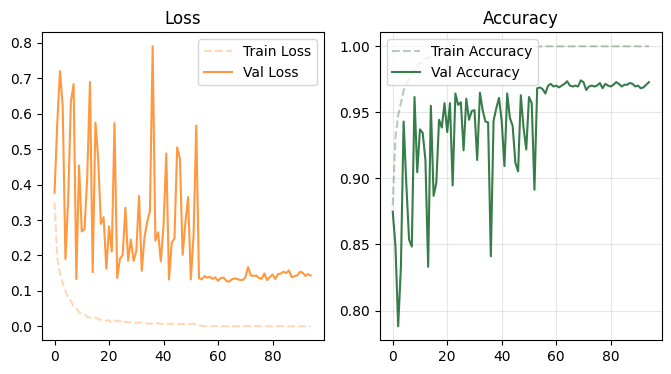

In [ ]:
plot_history(residual_history)

48/48 [==============================] - 1s 7ms/step
Accuracy: 0.9762, Precision: 0.9762, Recall: 0.9751, F1: 0.9755


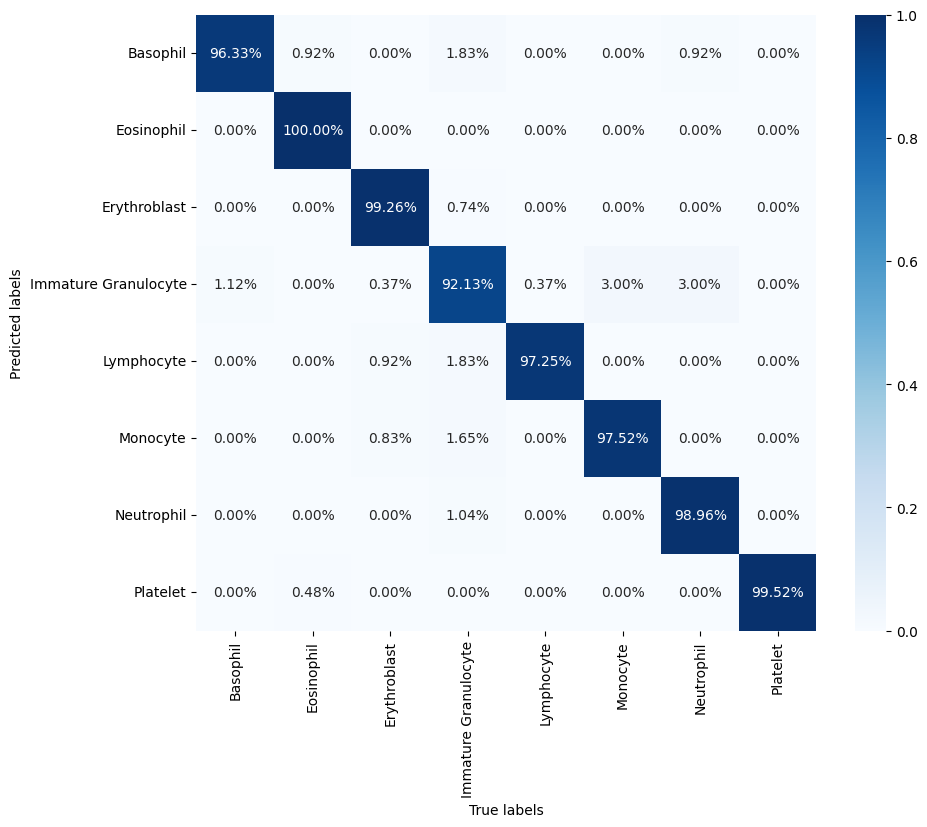

In [ ]:
predictions = residual_model.predict(X_test_aug_prep)
plot_test_results(y_test, predictions)

In [ ]:
residual_model.save('FinalModel')
save_history(residual_history, 'history_residual')

History successfully saved!


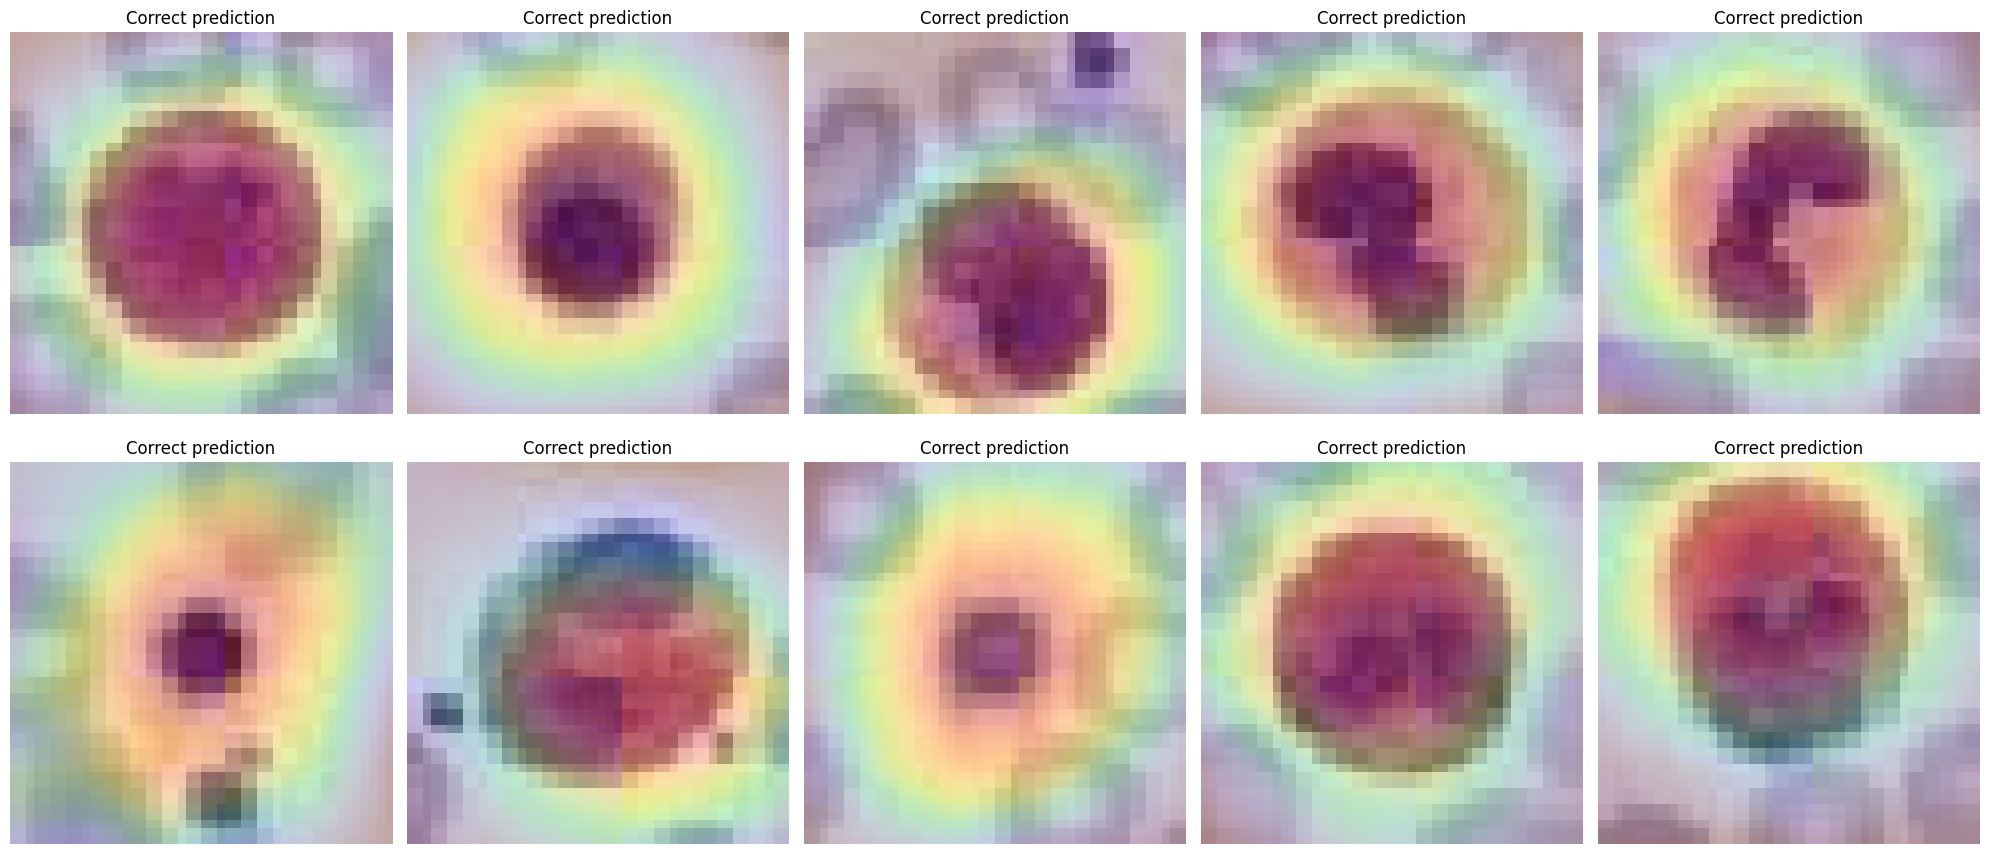

In [ ]:
values = []
for img in X_test_aug_prep[:10]:
    values.append(compute_CAM(residual_model, img))
values = np.array(values)


# Inspect the data
num_img = 10
fig, axes = plt.subplots(2, num_img//2, figsize=(20,9))
for i in range(num_img):
    ax = axes[i%2,i%num_img//2]
    ax.imshow(np.clip(X_test_aug_prep[i], 0, 255), alpha=1)
    ax.imshow(values[i][0], cmap='turbo', alpha=0.3)
    ax.set_title(tf(np.argmax(y_test[i]), values[i][1]))
    ax.axis('off')
plt.tight_layout()
plt.show()

The CAM seems to be quite satisfactory since the network always understand where the white cell is, and also the map indicates what triggers a cretain lebaling, so for the case of the smallest cells, the network detects a small violet object surrounded by a yellow space.

# Section 4: Comparison between models

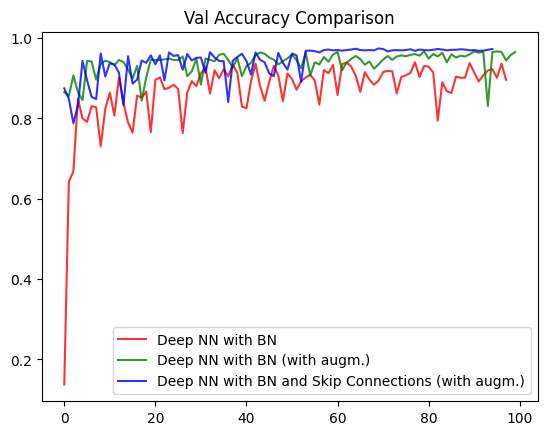

In [ ]:
bn_history = pd.read_csv('bn_vgg18_no_aug.csv')
bn_aug_history = pd.read_csv('bn_vgg18_aug.csv')
residual_history = pd.read_csv('history_residual.csv')

plt.plot(bn_history['val_accuracy'], alpha=.8, color='r', label = 'Deep NN with BN')
plt.plot(bn_aug_history['val_accuracy'], alpha=.8, color='g',  label = 'Deep NN with BN (with augm.)')
plt.plot(residual_history['val_accuracy'], alpha=.8, color='b', label = 'Deep NN with BN and Skip Connections (with augm.)')
plt.title('Val Accuracy Comparison')
plt.legend()
plt.show()

In [ ]:
# Accuracy comparisons on the test set for all the models

data = {
    'Model': ['Simple CNN 2', 'Deeper CNN Preproc', 'Deeper CNN Aug', 'VGG BN Aug', 'VGG BN SkipCon (Final)'],
    'Accuracy': [0.9517, 0.9483, 0.9517, 0.9682, 0.9762],
    'Precision': [0.9471, 0.9434, 0.9458, 0.9691, 0.9762],
    'Recall': [0.9458, 0.9406, 0.9451, 0.9619,0.9751],
    'F1': [0.9462, 0.9406, 0.9447,0.9653, 0.9755]
}

results = pd.DataFrame(data)
results

,Model,Accuracy,Precision,Recall,F1
0,Simple CNN 2,0.9517,0.9471,0.9458,0.9462
1,Deeper CNN Preproc,0.9483,0.9434,0.9406,0.9406
2,Deeper CNN Aug,0.9517,0.9458,0.9451,0.9447
3,VGG BN Aug,0.9682,0.9691,0.9619,0.9653
4,VGG BN SkipCon (Final),0.9762,0.9762,0.9751,0.9755
